In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import seaborn as sns

#these are user defined modules
import plot
import calculate

### Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

### Read Gender details

In [2]:
# read gender details - the column names are name, gender - change it to author, gender
gender = pd.read_csv('./data/name_gender_1970_2016_noAsians.csv')
gender.rename(columns={'name':'author'}, inplace=True)
print(gender.head())
print(gender['gender'].unique())
print(gender.groupby('gender').size())
#TODO: also show proportion! What is the percentage of men and women?

print(gender['author'].nunique())

             author gender
0    nima mesgarani      m
1    james j. abbas      m
2  eberhart zrenner      m
3    emery n. brown      m
4        ilya rybak      m
['m' 'none' 'f']
gender
f        974493
m       4493870
none     325482
dtype: int64
1129473


### Read authors with start and end year details

In [3]:
# Different files exists depending upon their career length
# CAREER_LENGTH = 15 means the authors who have atleast 15 years of experience
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
CAREER_LENGTH = 15
#max_years = 15

authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')

print('authorStartEndCareerData before filtering - ',authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData["start_year"] >= 1970]
print('authorStartEndCareerData after filtering - ',authorStartEndCareerData.shape[0])

#authorStartEndCareerData = pd.read_csv('data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')
print(authorStartEndCareerData.head())

#print("authorStartEndCareerData  %s", authorStartEndCareerData.shape[0])
print("author unique names  - ", authorStartEndCareerData['author'].nunique())
#print(authorStartEndCareerData[authorStartEndCareerData['author']=='a min tjoa'])

authorStartEndCareerData before filtering -  110468
authorStartEndCareerData after filtering -  110468
               author  start_year  end_year  pub_count  career_length
0          a min tjoa        1979      2015        193             36
1    a-imam al-sammak        1992      2008          6             16
2          a-xing zhu        1998      2015         16             17
3  a. a. (louis) beex        1980      2016         34             36
4     a. a. a. nasser        1993      2014          3             21
author unique names  -  110468


### Merge credible authors and their gender information

In [4]:
authorStartEndCareerData = pd.merge(authorStartEndCareerData, gender, how="left", on=["author"])
# for authors whose gender not found, replace it with none
authorStartEndCareerData['gender'] = authorStartEndCareerData['gender'].fillna('none')
print(authorStartEndCareerData.head())

print("authorStartEndCareerData with duplicates: %s", authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData.drop_duplicates()
print("authorStartEndCareerData no duplicates: %s", authorStartEndCareerData.shape[0])
# print(authorStartEndCareerData['author'].nunique())

#axes = authorStartEndCareerData.boxplot(column='pub_count', by='gender', return_type='axes')
#for ax in axes.values():
#    ax.set_ylim(0, 200)
#plt.show()


             author  start_year  end_year  pub_count  career_length gender
0        a min tjoa        1979      2015        193             36   none
1  a-imam al-sammak        1992      2008          6             16      m
2  a-imam al-sammak        1992      2008          6             16      m
3  a-imam al-sammak        1992      2008          6             16      m
4  a-imam al-sammak        1992      2008          6             16      m
authorStartEndCareerData with duplicates: %s 2365914
authorStartEndCareerData no duplicates: %s 110468


### Read Publication data

In [5]:
authorPublicationData = pd.read_csv('./data/author_publications_1970_2016_asiansAsNone.txt')
print('authorPublicationData before filtering - ',authorPublicationData.shape[0])
authorPublicationData = authorPublicationData[authorPublicationData["year"] >= 1970]
print('authorPublicationData after filtering - ',authorPublicationData.shape[0])

authorPublicationData = authorPublicationData.groupby(['year','author']).count().reset_index()
authorPublicationData.rename(columns={'pub_id':'num_pub'}, inplace=True)
print(authorPublicationData.head())

print(authorStartEndCareerData.head())
##remove wrong data
#authorPublicationData = authorPublicationData[authorPublicationData["year"] > 1900]
#print(authorPublicationData[authorPublicationData.author=="a min tjoa"])

print(np.unique(authorStartEndCareerData["start_year"]))


authorPublicationData before filtering -  9016290
authorPublicationData after filtering -  9016289
   year         author  num_pub
0  1970    a. a. afifi        1
1  1970    a. a. bährs        1
2  1970     a. armenti        1
3  1970  a. b. slomson        1
4  1970    a. brindley        1
                author  start_year  end_year  pub_count  career_length gender
0           a min tjoa        1979      2015        193             36   none
1     a-imam al-sammak        1992      2008          6             16      m
7           a-xing zhu        1998      2015         16             17   none
8   a. a. (louis) beex        1980      2016         34             36   none
42     a. a. a. nasser        1993      2014          3             21   none
[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001]


### Merge Publications with credible authors and their gender information

In [6]:
#authorPublicationData = pd.merge(authorPublicationData, authorStartEndCareerData,  
#                                          how="left", left_on="author", right_on="author")

authorPublicationData = pd.merge(authorPublicationData, authorStartEndCareerData, how="left", on=["author"])


print("authorPublicationData before filtering: %s", authorPublicationData.shape[0])
authorPublicationData = authorPublicationData.dropna(how='any')
print("authorPublicationData after filtering: %s", authorPublicationData.shape[0])

print("authorPublicationData with duplicates: %s", authorPublicationData.shape[0])
authorPublicationData = authorPublicationData.drop_duplicates()
print("authorPublicationData no duplicates: %s", authorPublicationData.shape[0])

#print(authorPublicationData.head(n=2))
print(authorPublicationData['author'].nunique())
#print(authorPublicationData.shape[0])

print(authorPublicationData.head())
#print(authorPublicationData[authorPublicationData.author=="a min tjoa"])


authorPublicationData before filtering: %s 4683626
authorPublicationData after filtering: %s 1247770
authorPublicationData with duplicates: %s 1247770
authorPublicationData no duplicates: %s 1247770
110468
    year                 author  num_pub  start_year  end_year  pub_count  \
4   1970            a. brindley        1      1970.0    2002.0        2.0   
5   1970  a. brinton cooper iii        2      1970.0    1996.0        5.0   
17  1970             a. j. cole        1      1970.0    1991.0        6.0   
22  1970            a. jennings        1      1970.0    1988.0        3.0   
23  1970               a. jones        1      1970.0    2014.0        9.0   

    career_length gender  
4            32.0   none  
5            26.0      m  
17           21.0   none  
22           18.0   none  
23           44.0   none  


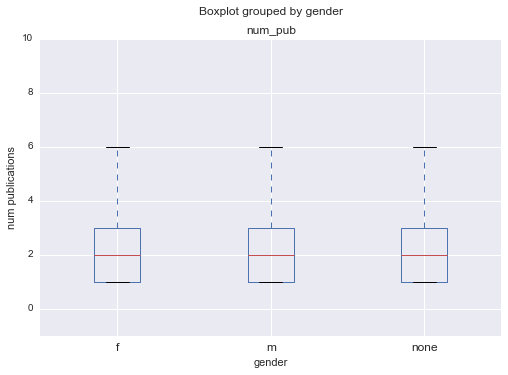

   year       author  num_pub  start_year  end_year  pub_count  career_length  \
4  1970  a. brindley        1      1970.0    2002.0        2.0           32.0   

  gender  
4   none  


In [7]:
pl = authorPublicationData.boxplot(column='num_pub', by='gender', showfliers=False)
pl.set_xlabel('gender')
pl.set_ylabel('num publications')
pl.set_ylim([-1,10])
plt.show()

print(authorPublicationData.head(n=1))

### Cohort Analysis on all authors for 15 years

In [8]:
print(authorPublicationData.head(n=1))

groupByYearData = authorPublicationData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(3))
print(np.unique(groupByYearData["year"]))

groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 1, 'num_pub')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(3))
print(np.unique(groupByYearData["year"]))

   year       author  num_pub  start_year  end_year  pub_count  career_length  \
4  1970  a. brindley        1      1970.0    2002.0        2.0           32.0   

  gender  
4   none  
        year            author  num_pub  start_year  end_year  pub_count  \
87873   1985  donatella sciuto        1      1985.0    2016.0      345.0   
116814  1987  donatella sciuto        1      1985.0    2016.0      345.0   
134709  1988  donatella sciuto        2      1985.0    2016.0      345.0   

        career_length gender  
87873            31.0      f  
116814           31.0      f  
134709           31.0      f  
[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016]
       year            author  num_pub  start_year  end_year  pub_count  \
46772  1985  donatella sciuto        1      1985.0    2016.0      345.0

In [9]:
years = groupByYearData['year'].unique()
years = sorted(years)
print(years)

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999]
   cohort_start_year  cohort_size    year      gini  career_age  \
0             1970.0      12109.0  1970.0  0.207495         0.0   
1             1970.0      12109.0  1971.0  0.295445         1.0   
2             1970.0      12109.0  1972.0  0.322718         2.0   
3             1970.0      12109.0  1973.0  0.272062         3.0   
4             1970.0      12109.0  1974.0  0.291757         4.0   

   ordered_cohort_start_year  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0  
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '', '']
['0.0', '0

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


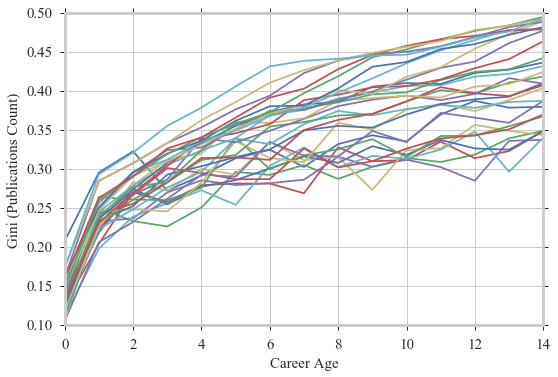

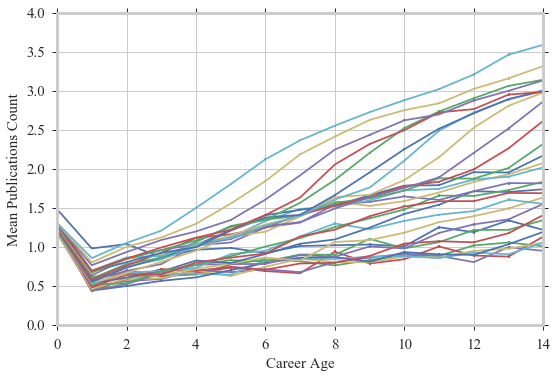

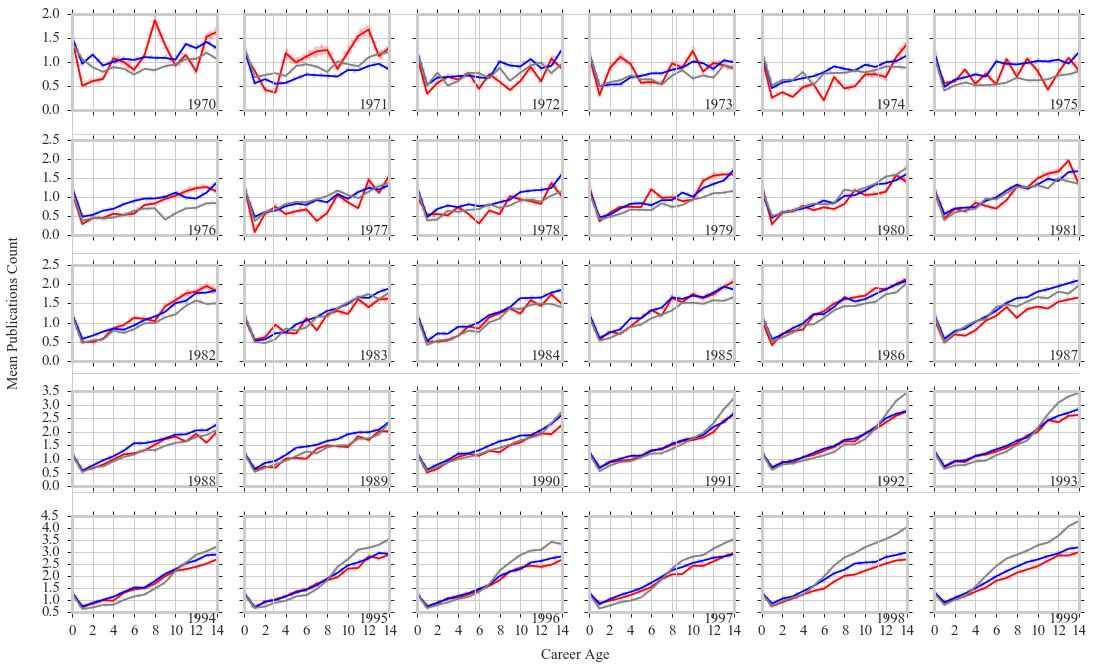

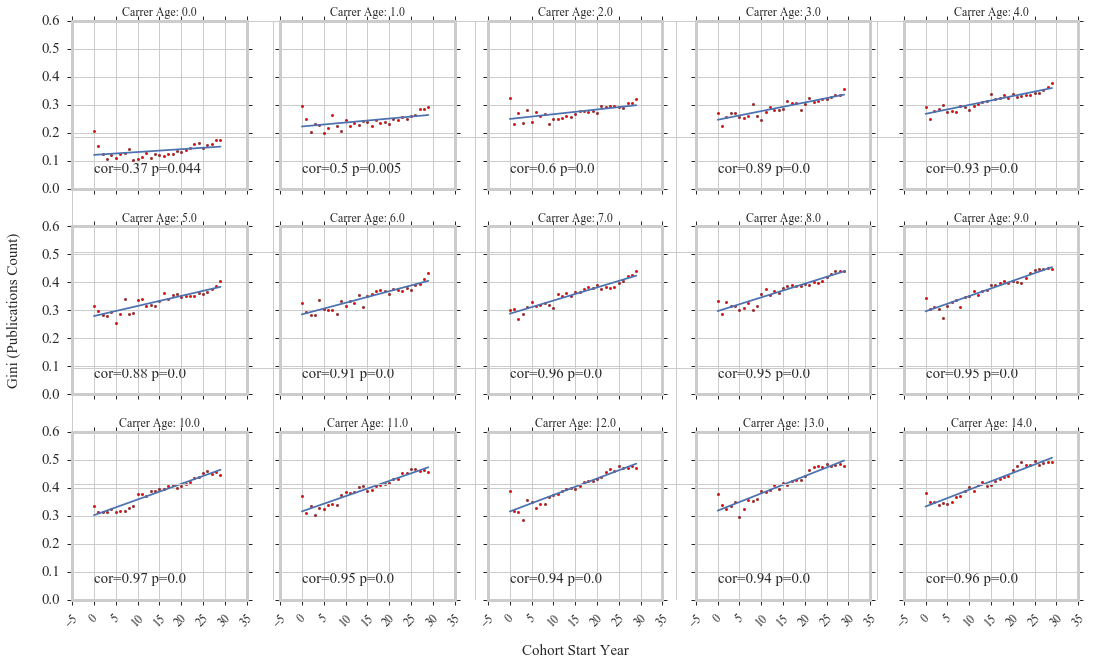

In [10]:
#just for debugging
#reload(plot)
#reload(calculate)
plot.plot_cohort_analysis_on(groupByYearData, 'num_pub', years, 15, 'Publications Count')

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999]
   cohort_start_year  cohort_size    year      gini  career_age  \
0             1970.0      12109.0  1970.0  0.207495         0.0   
1             1970.0      12109.0  1971.0  0.245035         1.0   
2             1970.0      12109.0  1972.0  0.299082         2.0   
3             1970.0      12109.0  1973.0  0.313380         3.0   
4             1970.0      12109.0  1974.0  0.328149         4.0   

   ordered_cohort_start_year  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0  
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '', '']
['0.0', '0

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


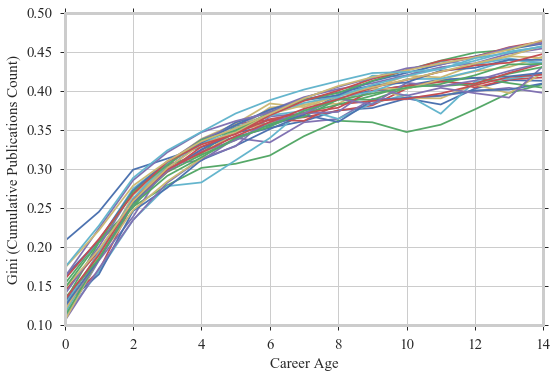

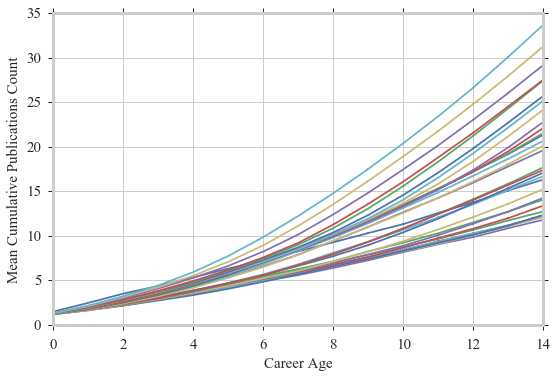

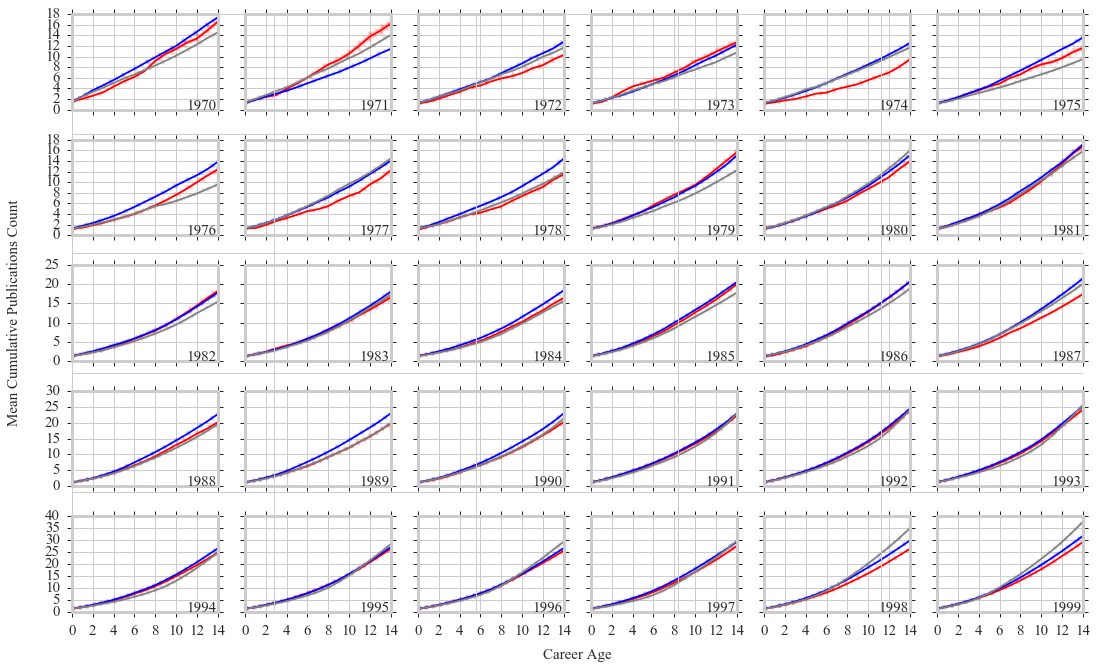

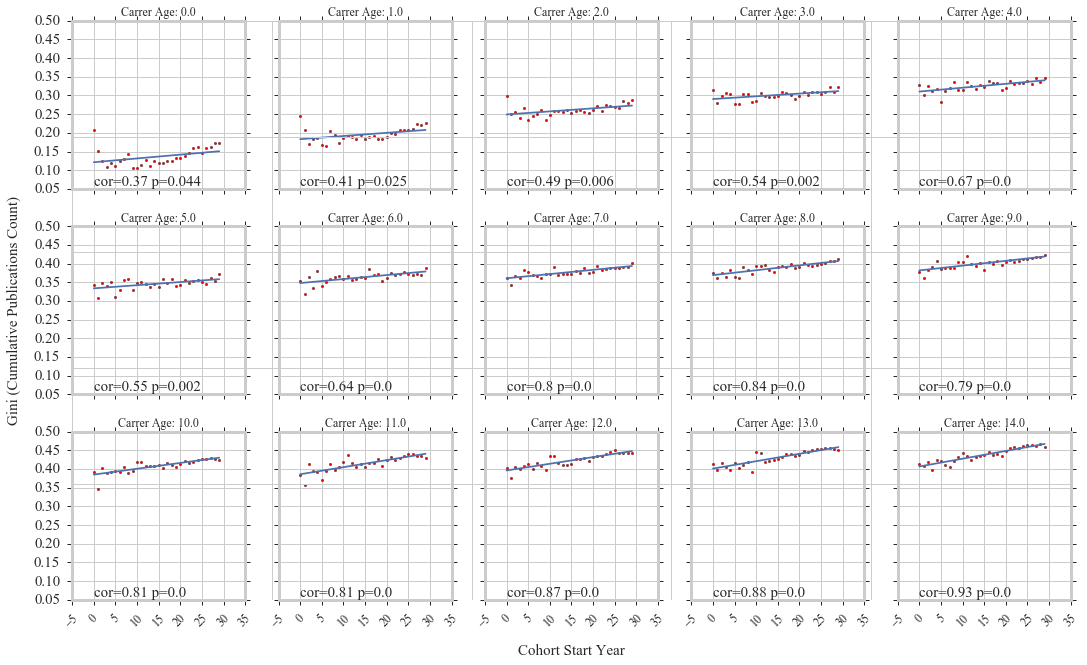

In [11]:
#just for debugging
#from importlib import reload
#reload(plot)
#reload(calculate)

plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_pub', years, 15,'Cumulative Publications Count')

#plot.plot_cohort_analysis_on(groupCitationsByAuthorYearData, 'num_cit', 'Citations Count')

### Regression Analysis of mean productivity on Inequality for all authors for 15 years

- There is no relation at all - Reg. coefficient is 0

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

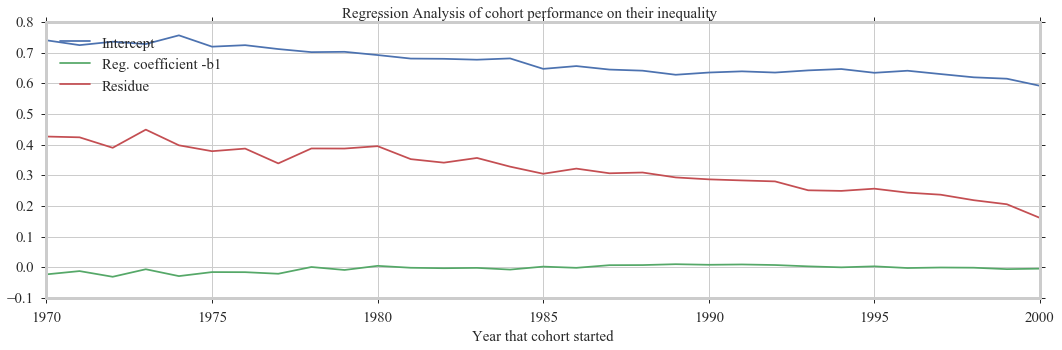

In [12]:
#just for debugging
#reload(plot)
#reload(calculate)
data = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_pub', years, 15)


C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

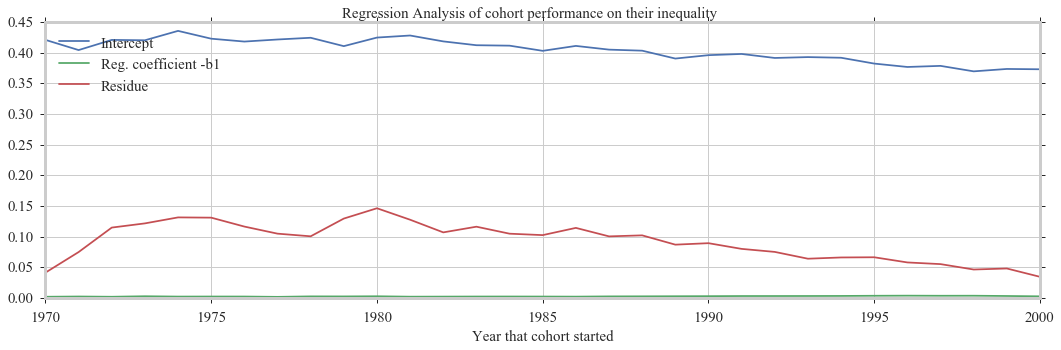

In [13]:
#just for debugging
#reload(plot)
#reload(calculate)
data = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_pub', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 2 years for 15 years

        year            author  num_pub  start_year  end_year  pub_count  \
87873   1985  donatella sciuto        1      1985.0    2016.0      345.0   
116814  1987  donatella sciuto        1      1985.0    2016.0      345.0   
134709  1988  donatella sciuto        2      1985.0    2016.0      345.0   
156018  1989  donatella sciuto        1      1985.0    2016.0      345.0   
180536  1990  donatella sciuto        2      1985.0    2016.0      345.0   
209531  1991  donatella sciuto        4      1985.0    2016.0      345.0   
242489  1992  donatella sciuto        4      1985.0    2016.0      345.0   
281488  1993  donatella sciuto        9      1985.0    2016.0      345.0   
327893  1994  donatella sciuto       13      1985.0    2016.0      345.0   
379792  1995  donatella sciuto       15      1985.0    2016.0      345.0   

        career_length gender  
87873            31.0      f  
116814           31.0      f  
134709           31.0      f  
156018           31.0      f  
180536  

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


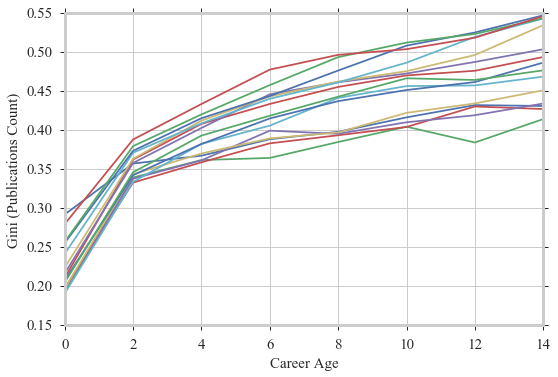

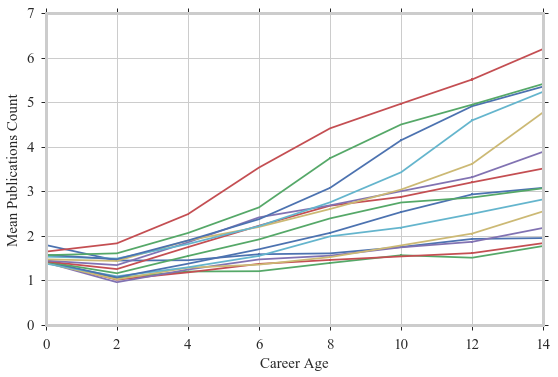

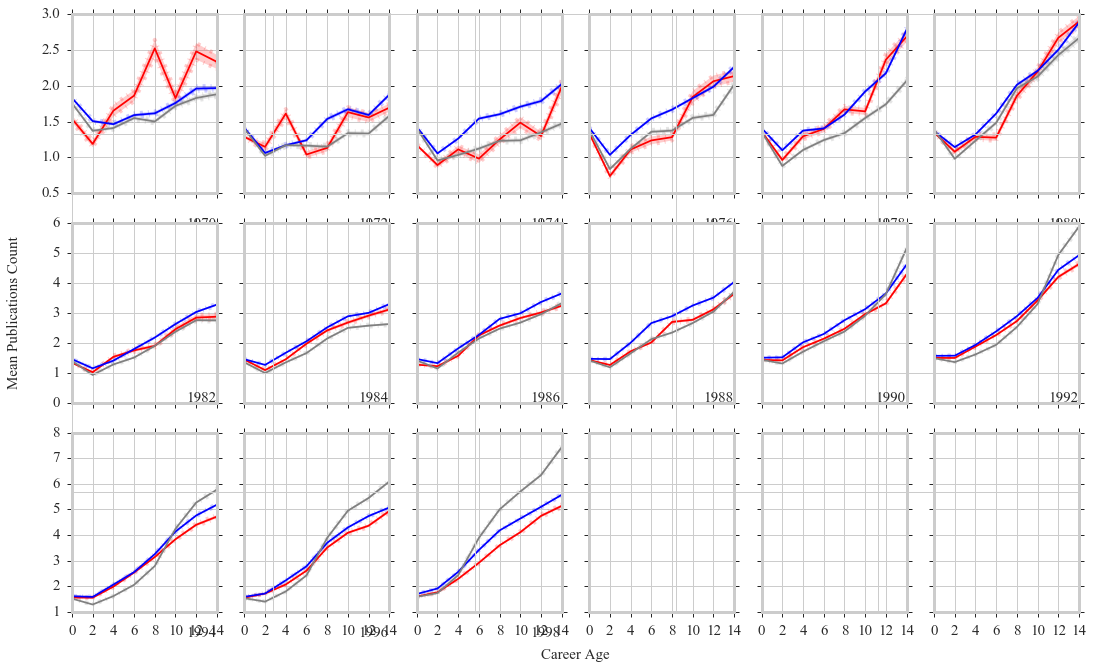

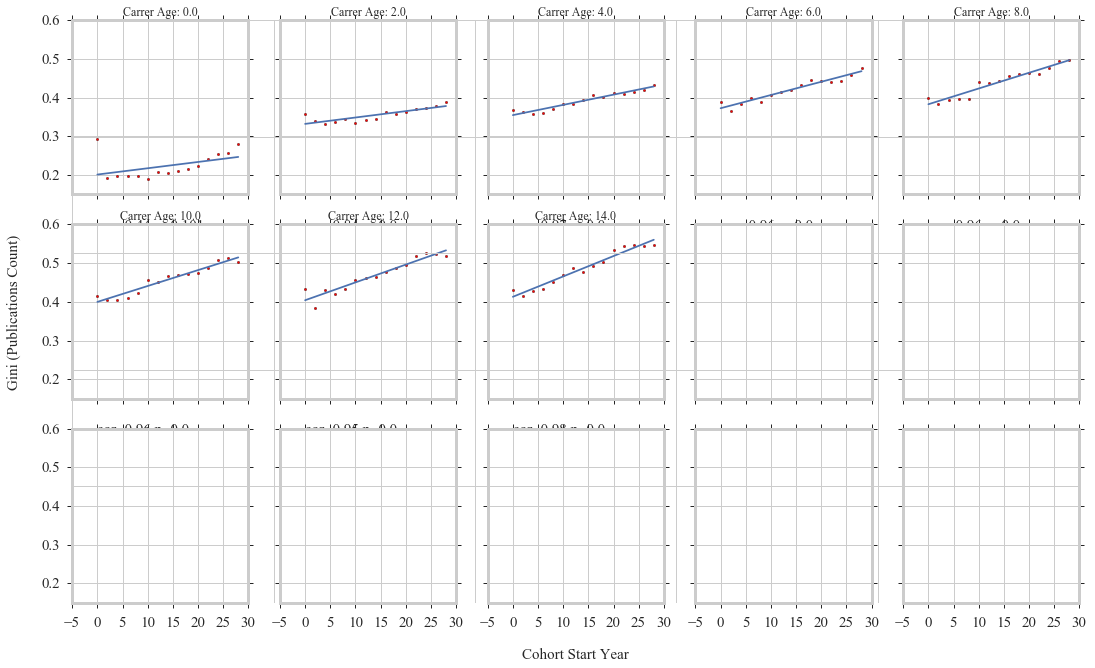

[1970, 1972, 1974, 1976, 1978, 1980, 1982, 1984, 1986, 1988, 1990, 1992, 1994, 1996, 1998]
   cohort_start_year  cohort_size    year      gini  career_age  \
0             1970.0      16700.0  1970.0  0.291619         0.0   
1             1970.0      16700.0  1972.0  0.311103         2.0   
2             1970.0      16700.0  1974.0  0.345375         4.0   
3             1970.0      16700.0  1976.0  0.358209         6.0   
4             1970.0      16700.0  1978.0  0.381123         8.0   

   ordered_cohort_start_year  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0  
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '']
['0.0', '0.2',

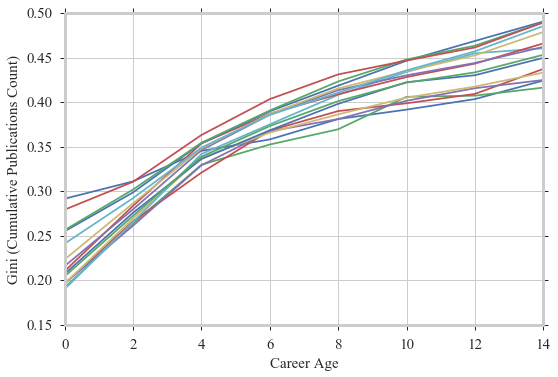

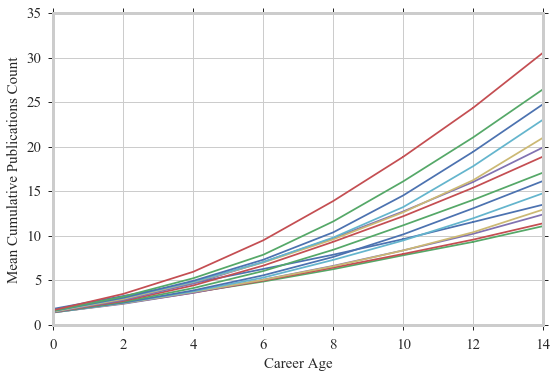

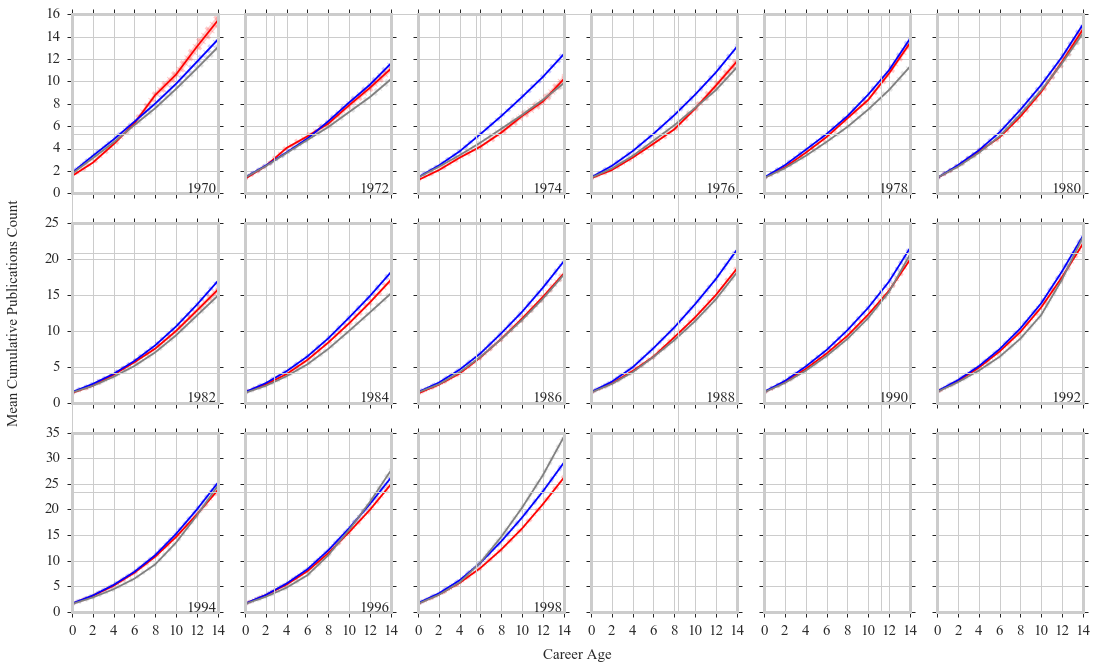

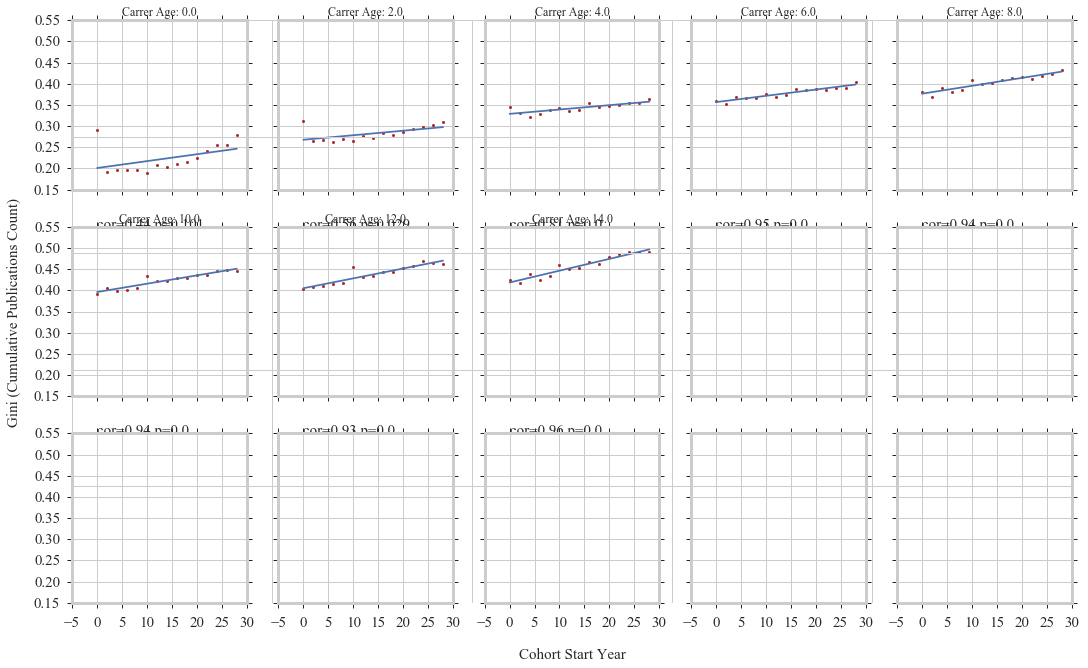

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

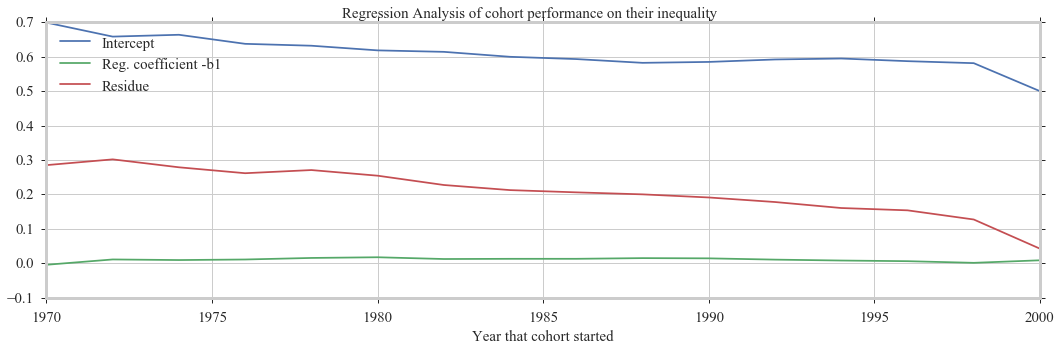

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

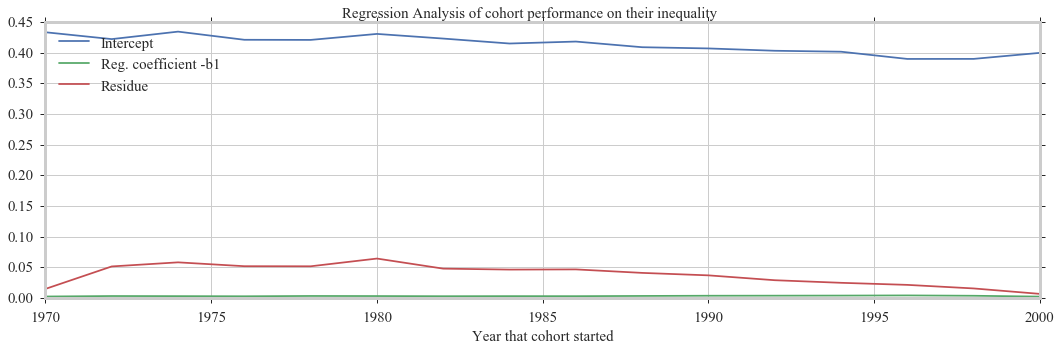

In [14]:
groupByYearData = authorPublicationData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_pub')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

years = groupByYearData['year'].unique()
years = sorted(years)
print(years)

plot.plot_cohort_analysis_on(groupByYearData, 'num_pub', years, 15, 'Publications Count')
plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_pub', years, 15, 'Cumulative Publications Count')
data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_pub', years, 15)
data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_pub', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 3 years for 15 years

        year            author  num_pub  start_year  end_year  pub_count  \
87873   1985  donatella sciuto        1      1985.0    2016.0      345.0   
116814  1987  donatella sciuto        1      1985.0    2016.0      345.0   
134709  1988  donatella sciuto        2      1985.0    2016.0      345.0   
156018  1989  donatella sciuto        1      1985.0    2016.0      345.0   
180536  1990  donatella sciuto        2      1985.0    2016.0      345.0   
209531  1991  donatella sciuto        4      1985.0    2016.0      345.0   
242489  1992  donatella sciuto        4      1985.0    2016.0      345.0   
281488  1993  donatella sciuto        9      1985.0    2016.0      345.0   
327893  1994  donatella sciuto       13      1985.0    2016.0      345.0   
379792  1995  donatella sciuto       15      1985.0    2016.0      345.0   

        career_length gender  
87873            31.0      f  
116814           31.0      f  
134709           31.0      f  
156018           31.0      f  
180536  

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


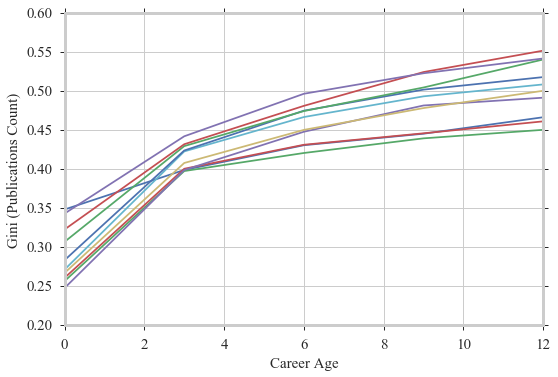

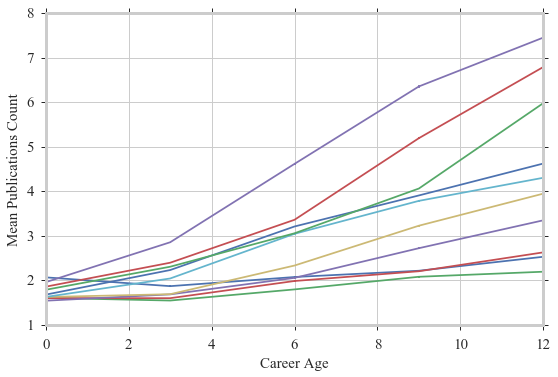

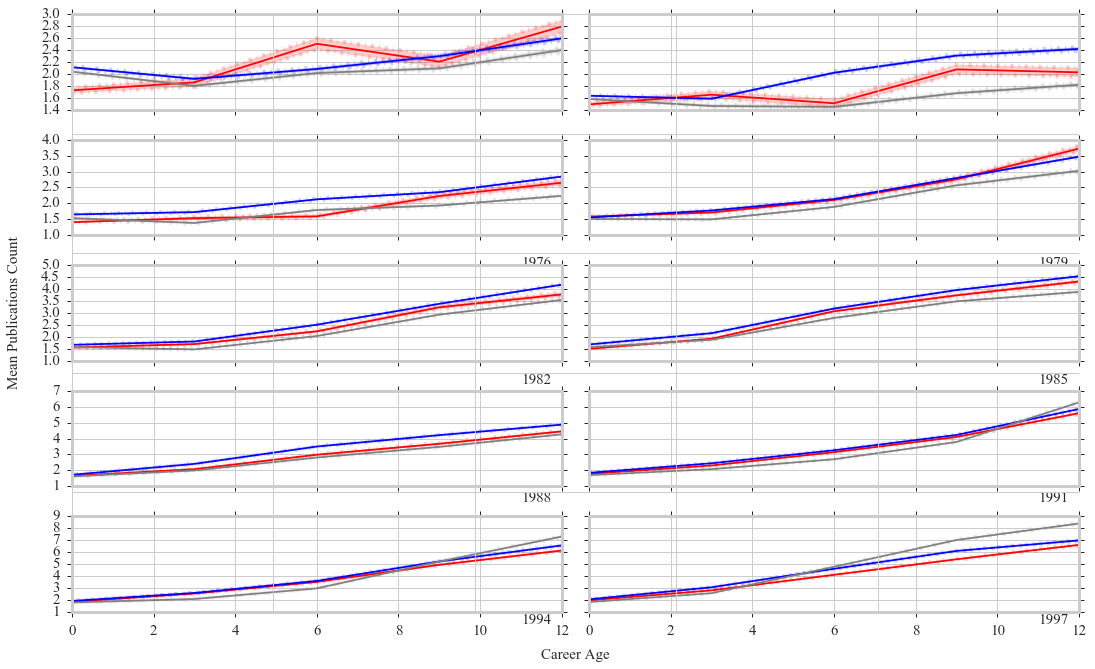

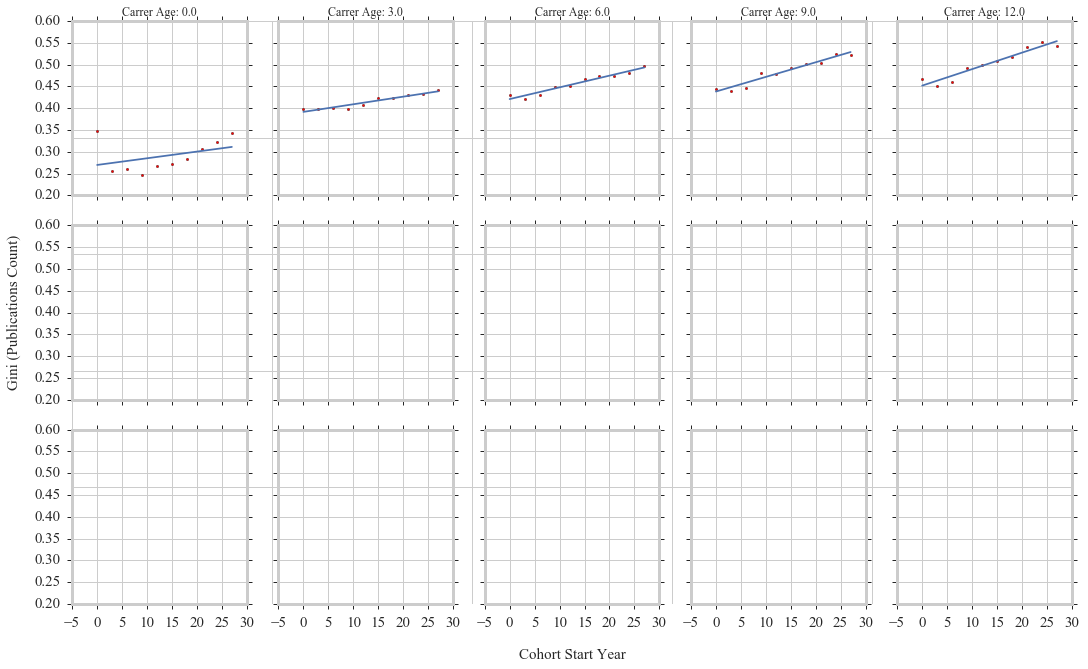

[1970, 1973, 1976, 1979, 1982, 1985, 1988, 1991, 1994, 1997]
   cohort_start_year  cohort_size    year      gini  career_age  \
0             1970.0      19013.0  1970.0  0.348037         0.0   
1             1970.0      19013.0  1973.0  0.347848         3.0   
2             1970.0      19013.0  1976.0  0.381514         6.0   
3             1970.0      19013.0  1979.0  0.402616         9.0   
4             1970.0      19013.0  1982.0  0.423575        12.0   

   ordered_cohort_start_year  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0  
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '']
['0.0', '0.2', '0.4', '0.6', '0.8', '1.0', '', '']


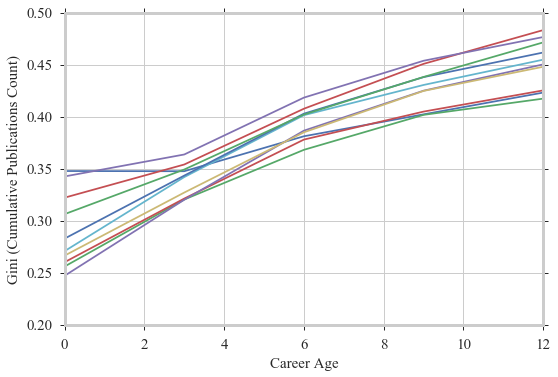

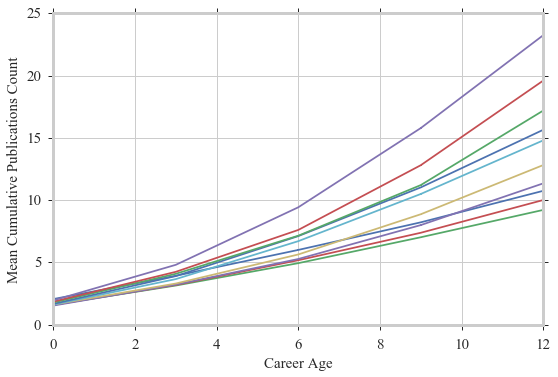

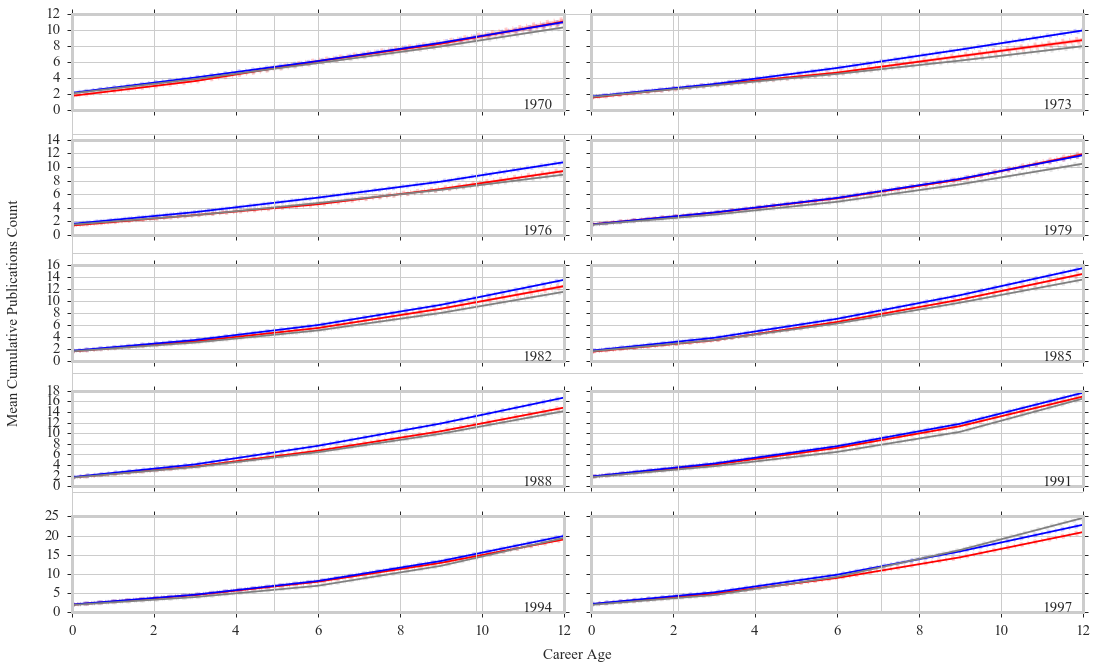

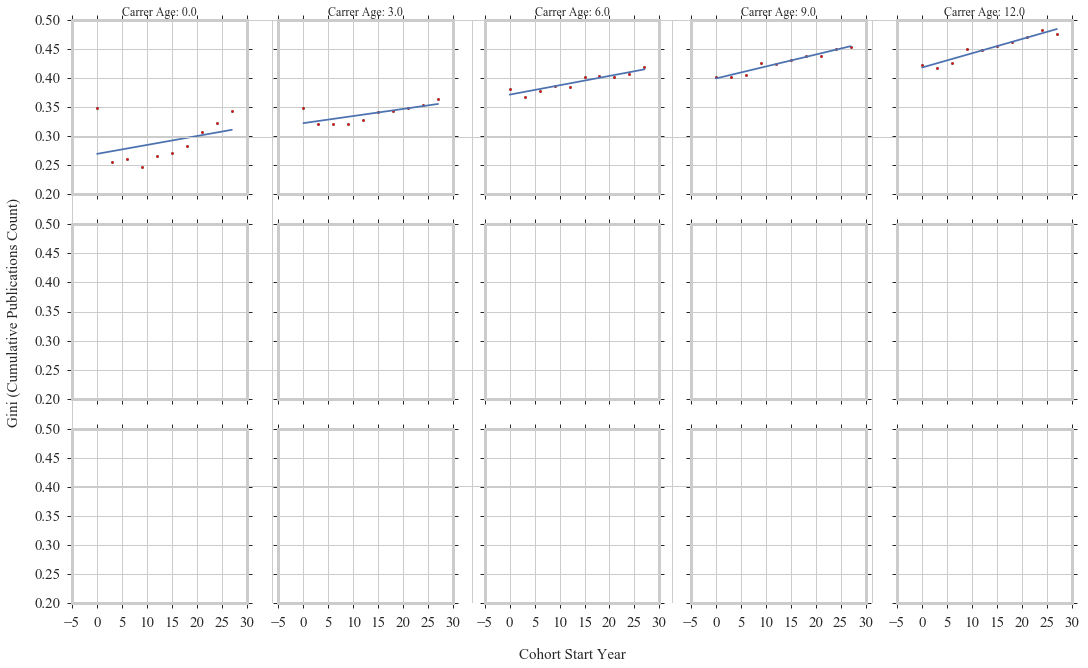

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

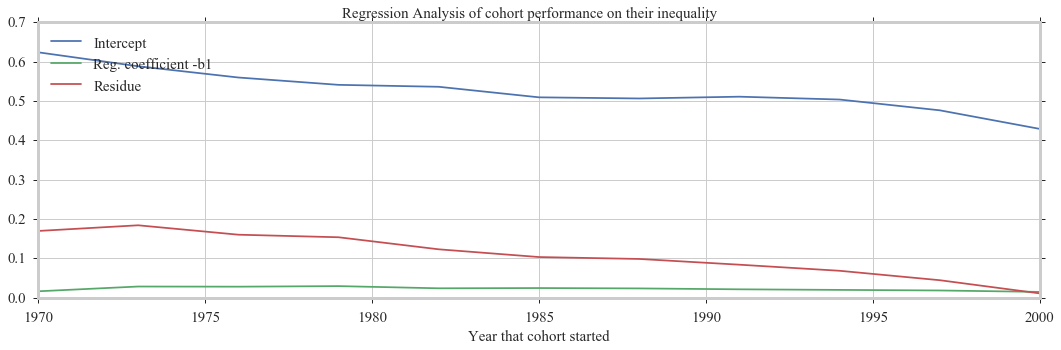

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

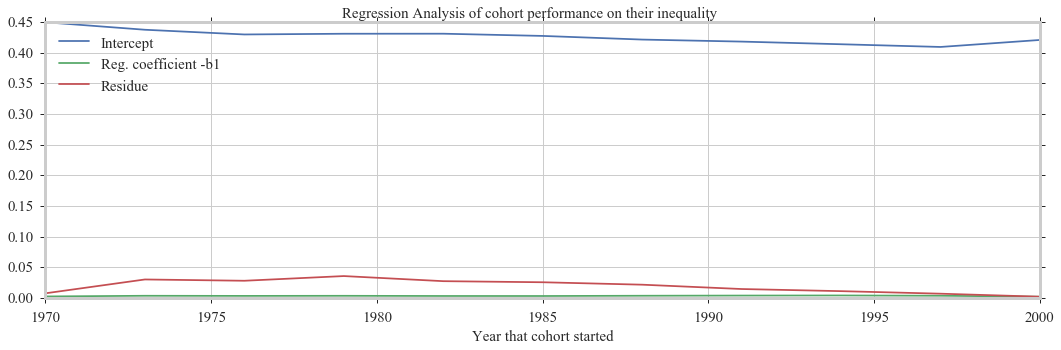

In [15]:
groupByYearData = authorPublicationData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_pub')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

years = groupByYearData['year'].unique()
years = sorted(years)
print(years)

plot.plot_cohort_analysis_on(groupByYearData, 'num_pub', years, 15, 'Publications Count')
plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_pub', years, 15, 'Cumulative Publications Count')
data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_pub', years, 15)
data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_pub', years, 15)